In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

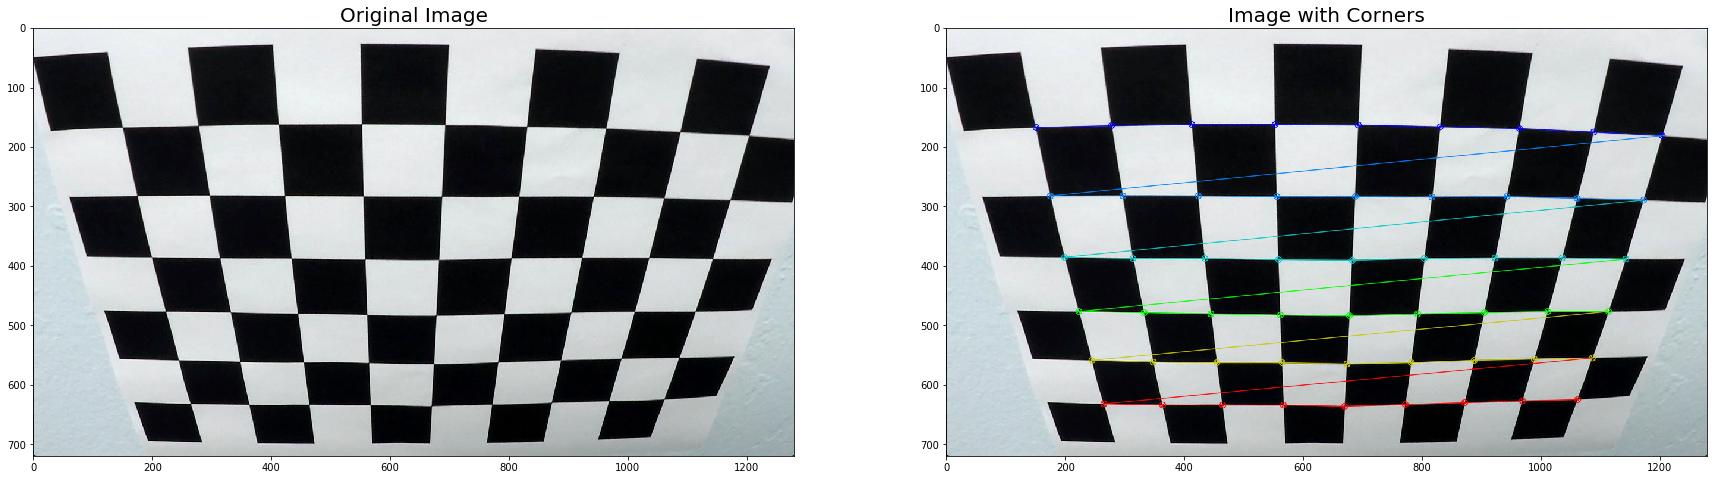

In [2]:
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints=[]
imgpoints=[] 
f, axes= plt.subplots(1,2,figsize=(30,30))
images = glob.glob('camera_cal/calibration*.jpg')



for index,image in enumerate(images):
    originalImage= cv2.imread(image)
    grayImg= cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY) 
    
    if(index==1 ):
        axes[0].set_title('Original Image', fontsize=20)
        axes[0].imshow(originalImage)
    ret, corners = cv2.findChessboardCorners(grayImg, (9,6), None)

    if(ret==True):
        objpoints.append(objp)
        imgpoints.append(corners)

        cv2.drawChessboardCorners(originalImage, (9,6), corners, ret)
        if(index==1):
            axes[1].set_title('Image with Corners', fontsize=20)
            axes[1].imshow(originalImage)


Text(0.5,1,'Undistorted')

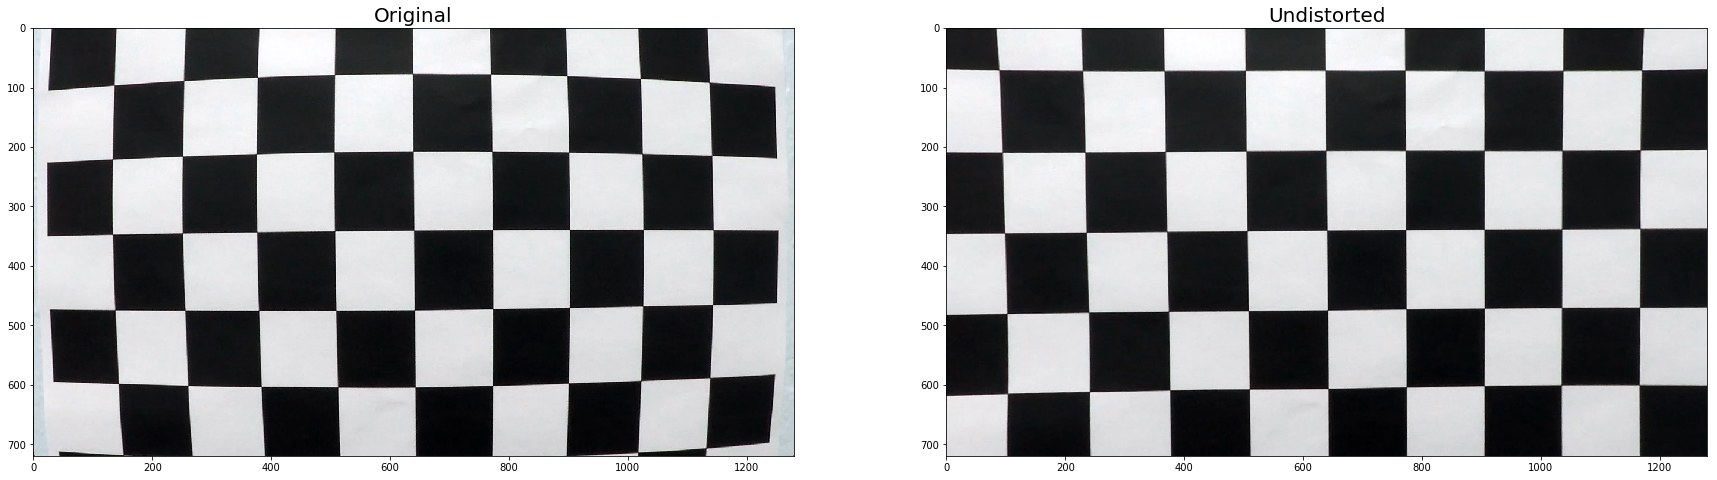

In [3]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

f, axes= plt.subplots(1,2,figsize=(30,30))

axes[0].imshow(img)
axes[0].set_title("Original", fontsize=20)
axes[1].imshow(dst)
axes[1].set_title("Undistorted", fontsize=20)


In [4]:

def undistortImage(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

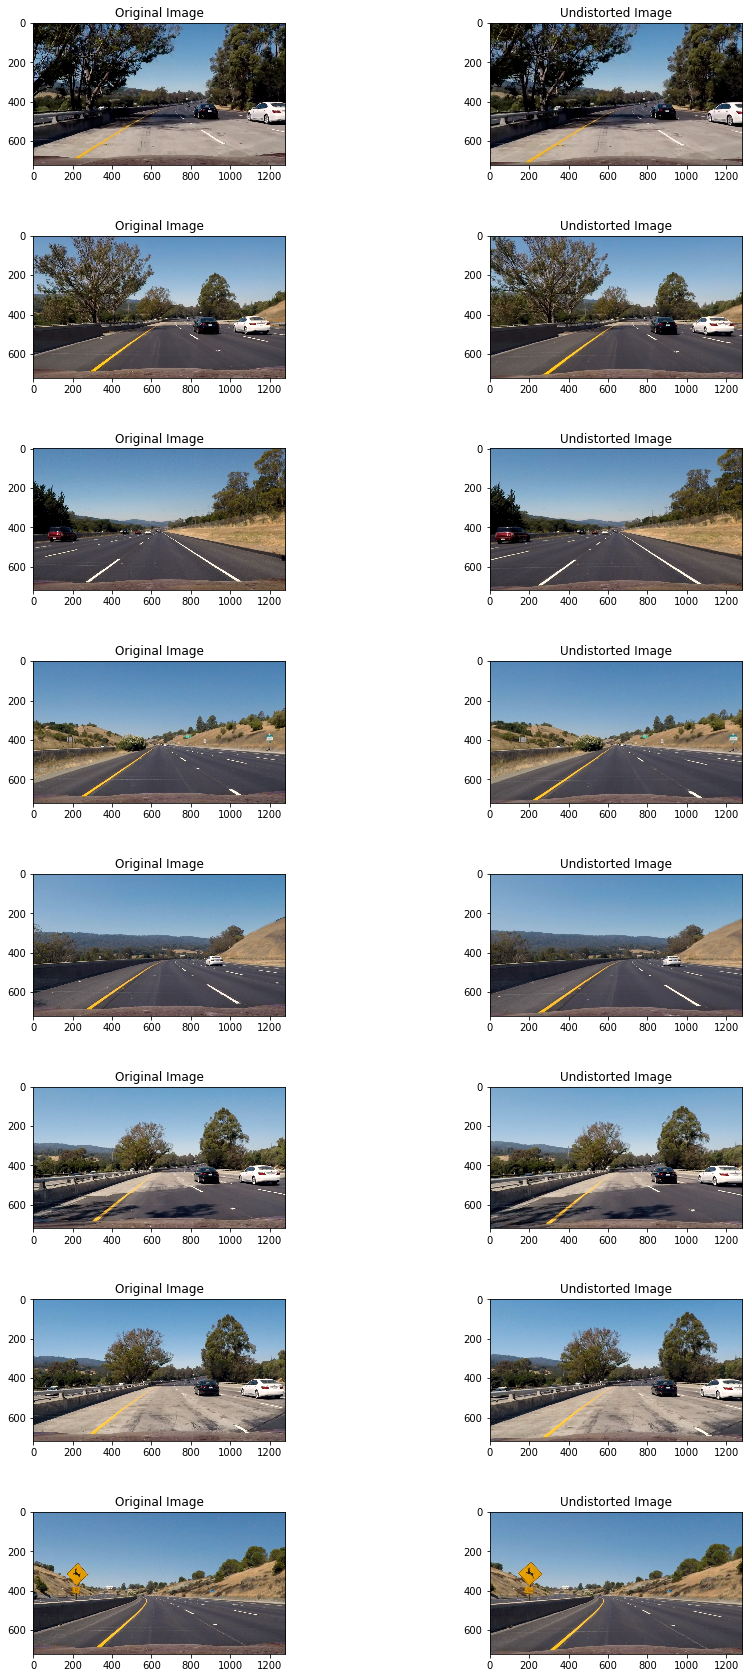

In [5]:

f, axes= plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

images = glob.glob('test_images/*.jpg') 
original_untouched_images=[]

for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    original_untouched_images.append(originalImage)
    axes[index,0].imshow(originalImage)
    axes[index,0].set_title("Original Image")
    undistortedImg=undistortImage(originalImage)
    axes[index,1].set_title("Undistorted Image")
    axes[index,1].imshow(undistortedImg)

In [6]:

left=[150,720] #left bottom most point of trapezium
right=[1250,720] #right bottom most point of trapezium
apex_left=[590,475] # left top most point of trapezium
apex_right=[700,475] # right top most point of trapezium

src=np.float32([left,apex_left,apex_right,right]) # Source Points for Image Warp
dst= np.float32([[200 ,720], [200  ,0], [980 ,0], [980 ,720]]) # Destination Points for Image Warp


def ROI(originalImage):
    return cv2.polylines(originalImage,np.int32(np.array([[left,apex_left,apex_right,right]])),True,(0,0,255),10)

def WarpPerspective(image):
    y=image.shape[0]
    x=image.shape[1]
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, (x,y), flags=cv2.INTER_LINEAR)

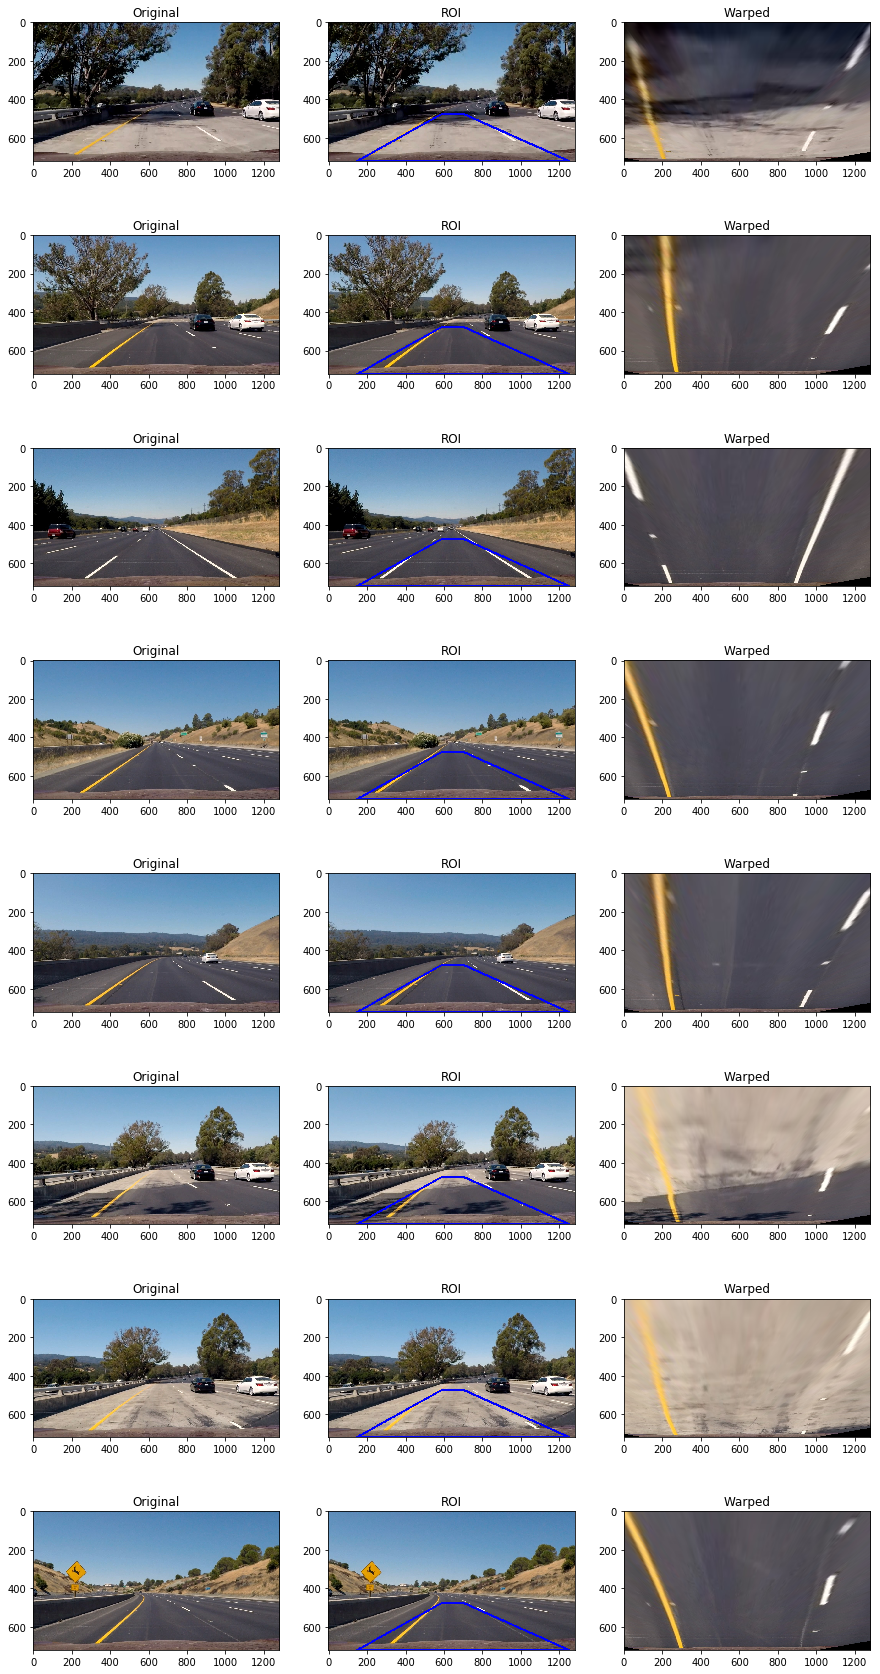

In [7]:

f, axes= plt.subplots(8,3,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

warpedImages=[]
for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    untouchedImage= originalImage.copy()
    axes[index,0].imshow(originalImage)
    axes[index,0].set_title("Original")
    ROI(originalImage)
    axes[index,1].imshow(originalImage)
    axes[index,1].set_title("ROI")
    y=untouchedImage.shape[0]
    x=untouchedImage.shape[1]
    warped = WarpPerspective(untouchedImage)
    warpedImages.append(warped)
    axes[index,2].imshow(warped)
    axes[index,2].set_title("Warped")

In [8]:
def ExtractChannel(image,colorspace,threshold,channel=0):
    colorspace = cv2.cvtColor(image, colorspace)
    extracted_channel = colorspace[:,:,channel]
    binary = np.zeros_like(extracted_channel)
    binary[(extracted_channel >= threshold[0]) & (extracted_channel <= threshold[1])] = 1
    return binary

Text(0.5,1,'S')

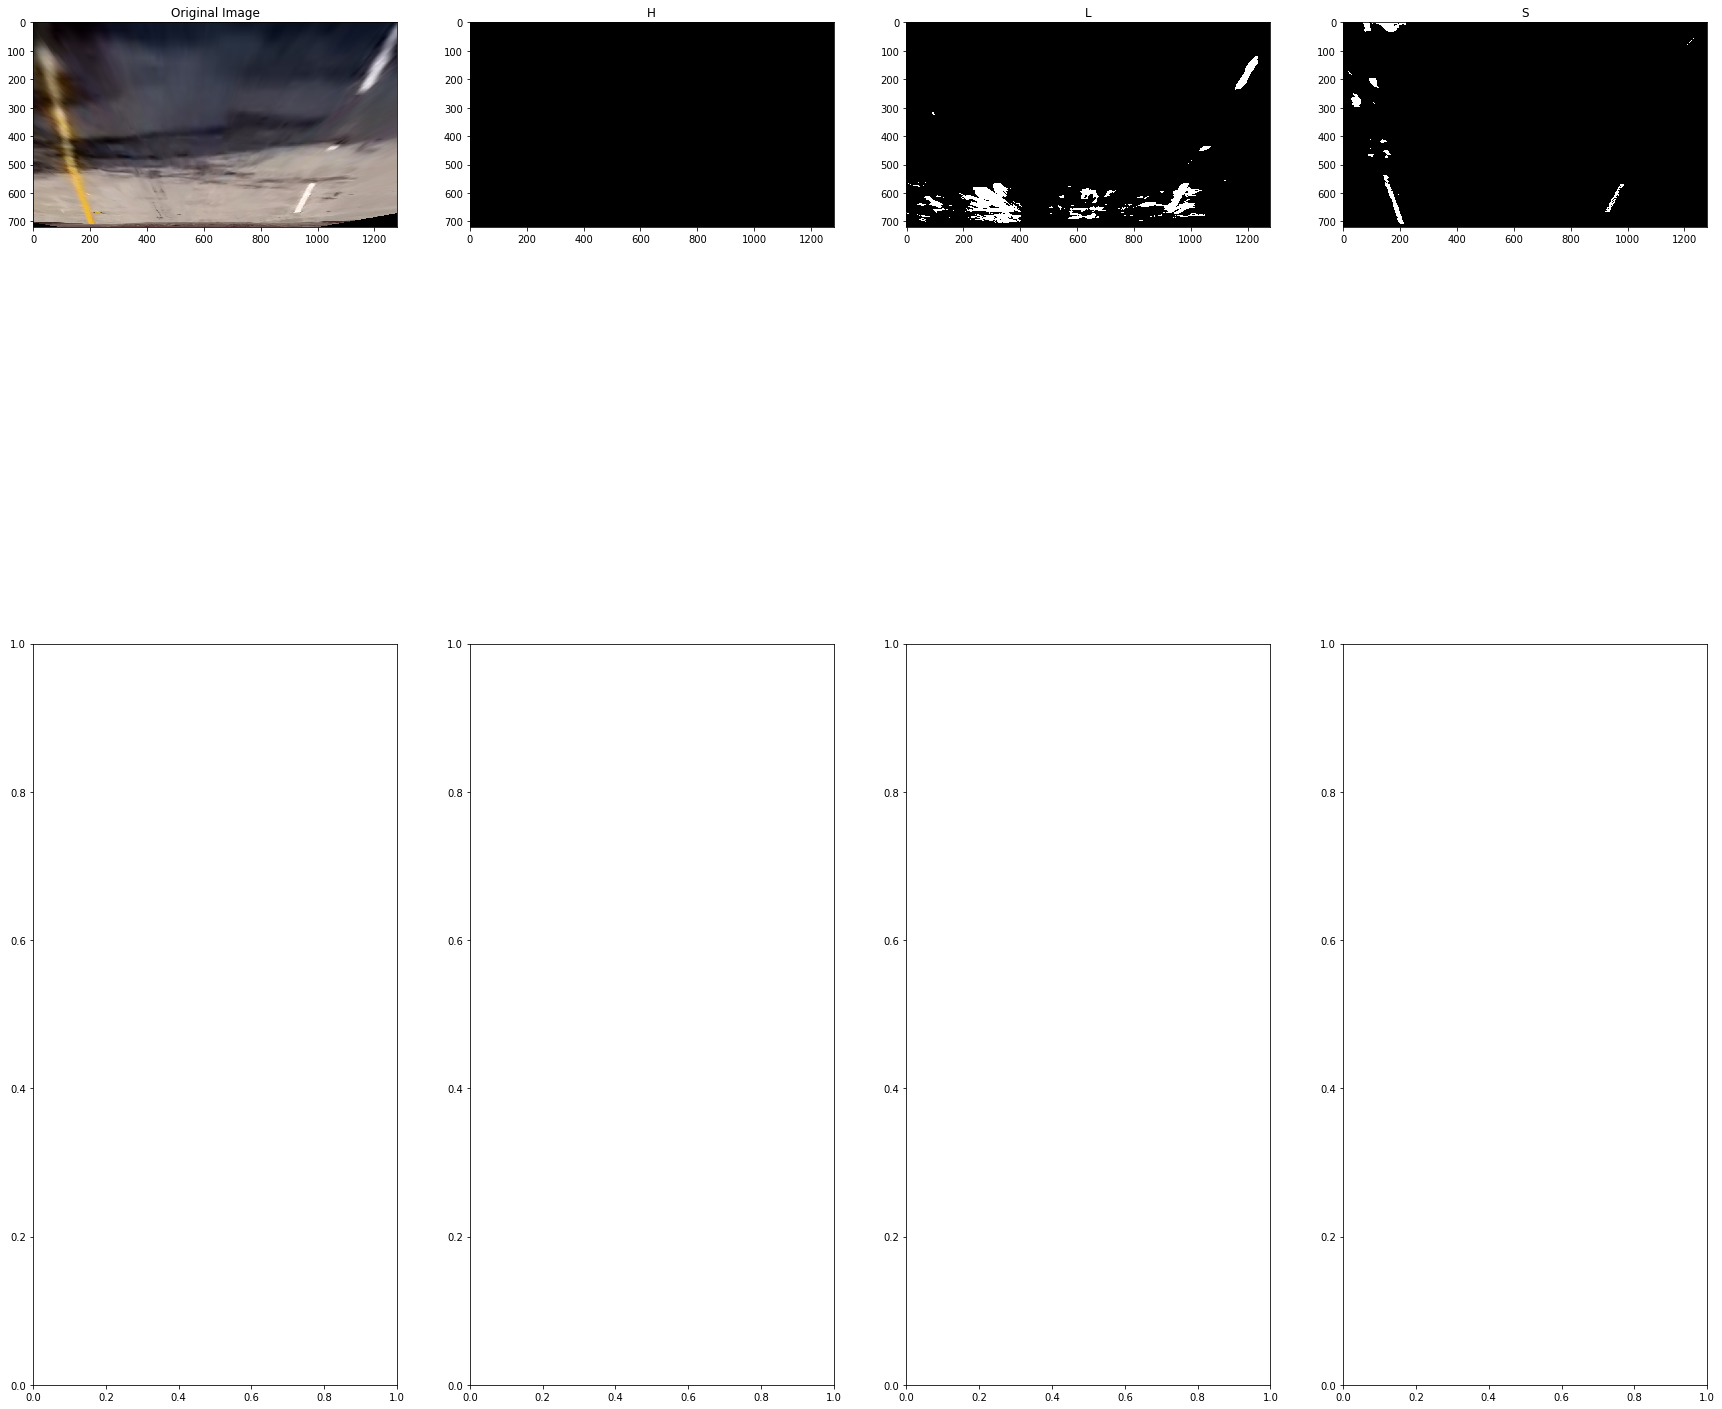

In [9]:
f, axes= plt.subplots(2,4,figsize=(30,30))

image=warpedImages[0]


threshold= [180,255]
index=0
axes[index,0].imshow(image)
axes[index,0].set_title("Original Image")


h=ExtractChannel(image, cv2.COLOR_RGB2HLS ,threshold,0)
axes[index,1].imshow(h,cmap='gray')
axes[index,1].set_title("H")

l=ExtractChannel(image, cv2.COLOR_RGB2HLS ,threshold,1)
axes[index,2].imshow(l,cmap='gray')
axes[index,2].set_title("L")

s=ExtractChannel(image, cv2.COLOR_RGB2HLS ,threshold,2)
axes[index,3].imshow(s,cmap='gray')
axes[index,3].set_title("S")


In [10]:
def Sobel(warpedimage, threshold, sobelType, kernelSize=3):
    
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY) # Step 1- Convert to GrayScale
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=kernelSize)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=kernelSize)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad= np.sqrt(sobelx**2 + sobely**2)
    
    arctan= np.arctan2(abs_sobely,abs_sobelx)
    
    valParam=abs_sobelx
    
    if(sobelType=='x'):
        valParam=abs_sobelx
    elif(sobelType=='y'):
        valParam= abs_sobely
    elif(sobelType=='xy'):
        valParam= grad
    else:
        valParam=arctan
        
    
    img = np.uint8((valParam* 255)/np.max(valParam)) # Creating a normalized sobel image
    binary_output = np.zeros_like(img)
    binary_output[(img > threshold[0]) & (img < threshold[1])]=1
    return binary_output

Text(0.5,1,'Sobel Direction')

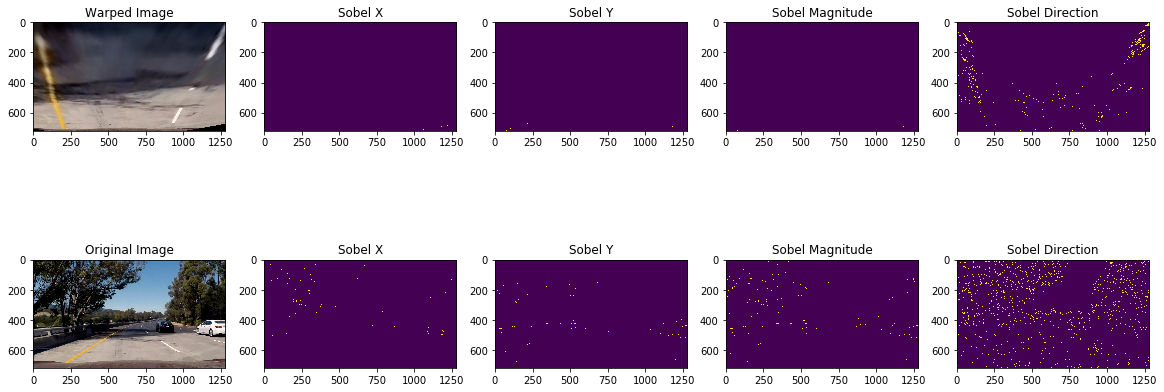

In [11]:
f, axes= plt.subplots(2,5,figsize=(20,8))

threshold=[100,120]
originalImage= images[0]
originalImage= cv2.cvtColor(cv2.imread(originalImage), cv2.COLOR_BGR2RGB)
index=0

axes[index,0].imshow(image)
axes[index,0].set_title("Warped Image")

sobelx=Sobel(image,threshold,'x')
axes[index,1].imshow(sobelx)
axes[index,1].set_title("Sobel X")

sobely=Sobel(image,threshold,'y')
axes[index,2].imshow(sobely)
axes[index,2].set_title("Sobel Y")

sobelxy=Sobel(image,threshold,'xy')
axes[index,3].imshow(sobelxy)
axes[index,3].set_title("Sobel Magnitude")

sobeldir=Sobel(image,threshold,'dir')
axes[index,4].imshow(sobeldir)
axes[index,4].set_title("Sobel Direction")

index=index+1

axes[index,0].imshow(originalImage)
axes[index,0].set_title("Original Image")

sobelx=Sobel(originalImage,threshold,'x')
axes[index,1].imshow(sobelx)
axes[index,1].set_title("Sobel X")

sobely=Sobel(originalImage,threshold,'y')
axes[index,2].imshow(sobely)
axes[index,2].set_title("Sobel Y")

sobelxy=Sobel(originalImage,threshold,'xy')
axes[index,3].imshow(sobelxy)
axes[index,3].set_title("Sobel Magnitude")

sobeldir=Sobel(originalImage,threshold,'dir')
axes[index,4].imshow(sobeldir)
axes[index,4].set_title("Sobel Direction")

In [12]:
def combineEverything(warpedImage, color_threshold, sobel_threshold):
    
    s_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,2)
    l_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,1)
    y_channel= ExtractChannel(warpedImage,cv2.COLOR_RGB2YUV,color_threshold,0)
    
    sobelx = Sobel(warpedImage, sobel_threshold, 'x')
    sobeldir= Sobel(warpedImage, [10,20], 'dir')
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(((s_channel == 1) & (l_channel==1)) & (y_channel==1)) | (sobelx == 1)  ] = 1
    return combined_binary

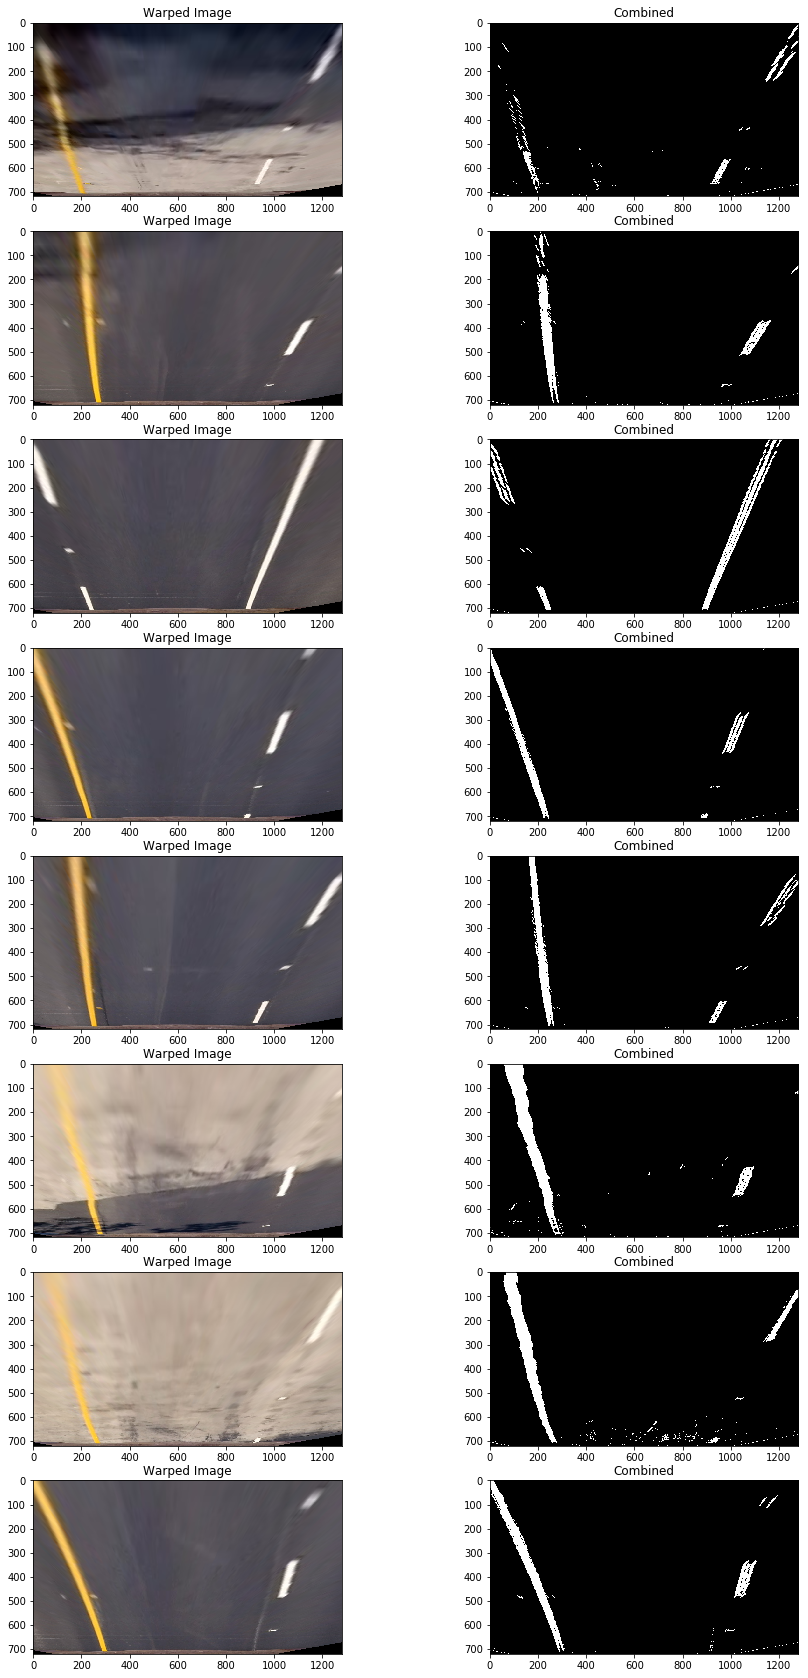

In [13]:
f, axes= plt.subplots(8,2,figsize=(15,30))

for index,warped in enumerate(warpedImages):
    combinedImage=combineEverything(warped,[150,255],[30,255])
    axes[index,0].imshow(warped)
    axes[index,0].set_title("Warped Image")
    axes[index,1].imshow(combinedImage,cmap='gray')
    axes[index,1].set_title("Combined")

In [14]:
def Histogram(warpedimage):
    return np.sum(warpedimage[warpedimage.shape[0]//2:,:], axis=0)

Text(0.5,1,'Histogram')

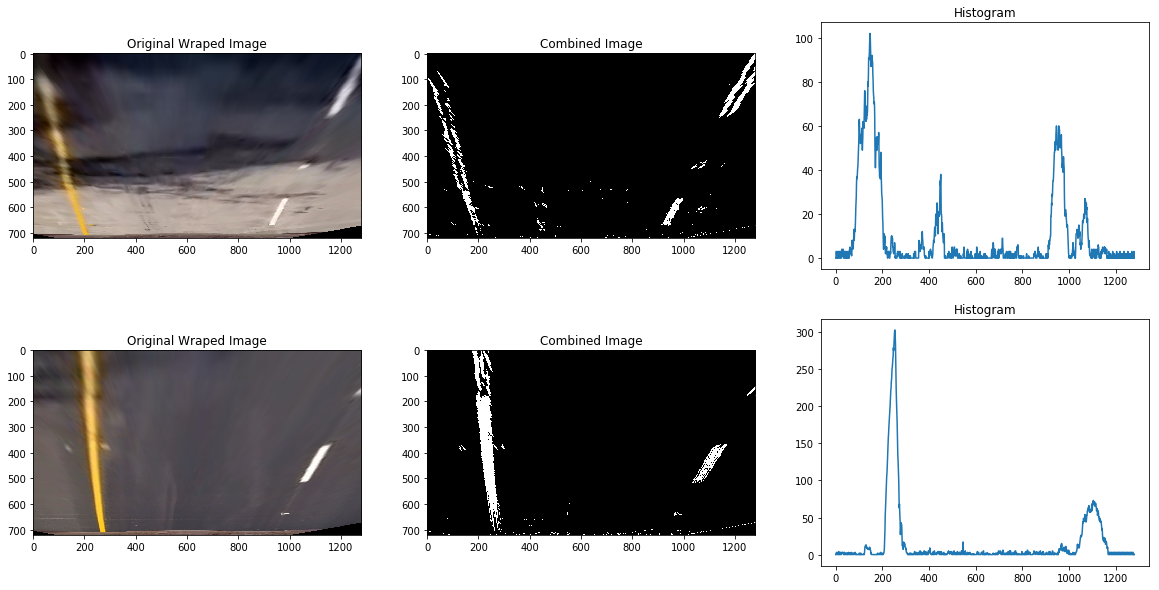

In [15]:
f, axes= plt.subplots(2,3,figsize=(20,10))

index=0


axes[index,0].imshow(image)
axes[index,0].set_title("Original Wraped Image")
combinedImage=combineEverything(image,[150,255],[20,100])
axes[index,1].imshow(combinedImage,cmap="gray")
axes[index,1].set_title("Combined Image")
histogram = Histogram(combinedImage)
axes[index,2].plot(histogram)
axes[index,2].set_title("Histogram")


image2= warpedImages[1]
index=index+1

axes[index,0].imshow(image2)
axes[index,0].set_title("Original Wraped Image")
combinedImage1=combineEverything(image2,[150,255],[20,100])
axes[index,1].imshow(combinedImage1,cmap="gray")
axes[index,1].set_title("Combined Image")
histogram = Histogram(combinedImage1)
axes[index,2].plot(histogram)
axes[index,2].set_title("Histogram")

In [16]:
def SlidingWindowSearch(binary_warped, plot=False):

    histogram = Histogram(binary_warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
  
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 12
  
    window_height = np.int(binary_warped.shape[0]/nwindows)
  
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base
   
    margin = 100
   
    minpix = 60
   
    left_lane_inds = []
    right_lane_inds = []

   
    for window in range(nwindows):
       
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if(plot==True):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
       
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
     
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
      
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img

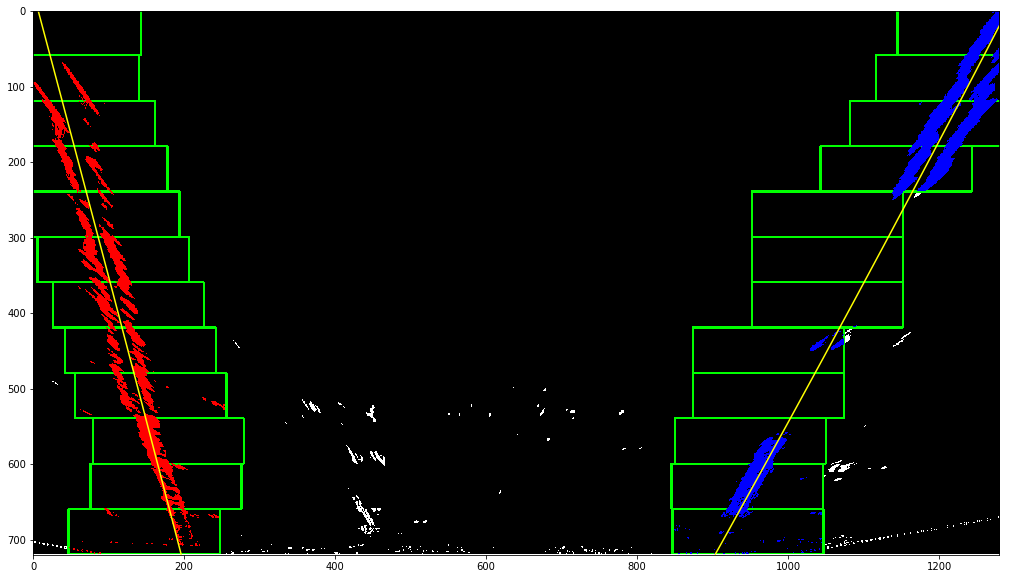

In [17]:
def VisualizeSlidingWindow(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure(figsize=(20,10))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #return out_img

l,r,ld,rd,o=SlidingWindowSearch(combinedImage, plot=True)
VisualizeSlidingWindow(combinedImage,l,r,ld,rd,o)

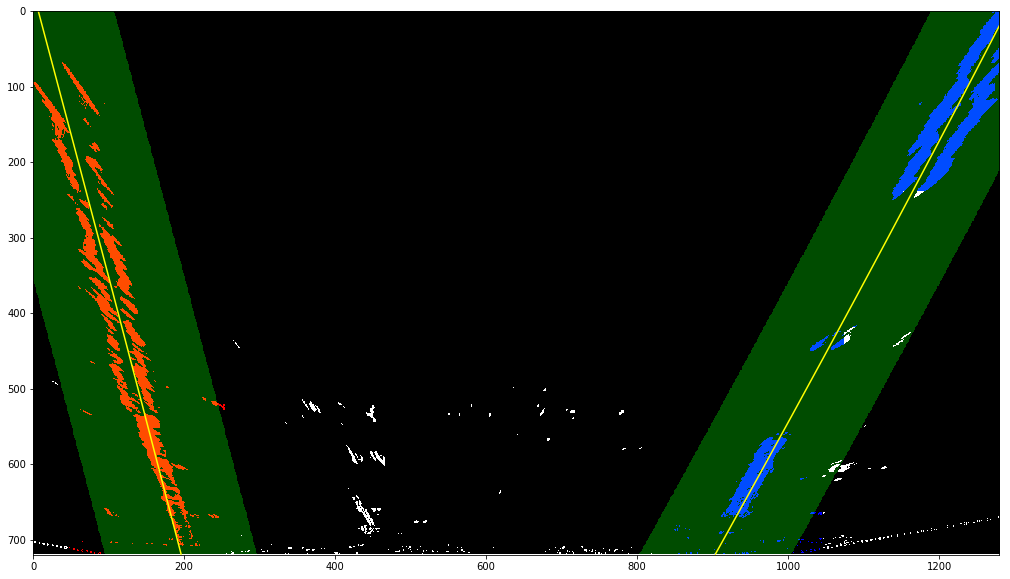

In [18]:
def VisualizeLaneDetection(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    

    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

l,r,ld,rd,o=SlidingWindowSearch(combinedImage, plot=False)
VisualizeLaneDetection(combinedImage,l,r,ld,rd,o)

In [19]:
def DrawLine(original_image,binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    ploty = np.linspace(0, h-1, num=h)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
   
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

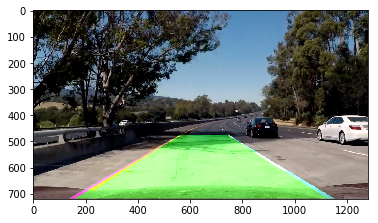

In [20]:
originalImage= images[0]
originalImage=cv2.cvtColor(cv2.imread(originalImage), cv2.COLOR_BGR2RGB)
returnedOutput =  SlidingWindowSearch(combinedImage)
left_fit=returnedOutput[0]
right_fit=returnedOutput[1]
finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
plt.imshow(finalImage)

In [21]:
def CalculateRadiusOfCurvature(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    positionCar= binary_warped.shape[1]/2
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (positionCar - actualPosition)* xm_per_pix
    
    
    return (left_curverad + right_curverad)/2, distance


In [22]:
import random
import datetime
import time

def pipeline(originalImage):
    originalImage= cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
    undistortedImage= undistortImage(originalImage)
    warpedImage= WarpPerspective(undistortedImage)
    combinedImage= combineEverything(warpedImage,color_threshold= [100,255],sobel_threshold=[10,150])
    returnedOutput =  SlidingWindowSearch(combinedImage)
    left_fit=returnedOutput[0]
    right_fit=returnedOutput[1]
    finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
        
    radius, distance = CalculateRadiusOfCurvature(combinedImage,left_fit,right_fit)
    cv2.putText(finalImage,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    cv2.putText(finalImage,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
     
             
    cv2.imwrite('./Output_1/'+str(random.randint(0,1000))+'.jpg',originalImage)
        
    cv2.imwrite('./Output_1/'+str(random.randint(0,1000))+'_o.jpg',finalImage)
    newCombinedImage= np.dstack((combinedImage*255,combinedImage*255,combinedImage*255))
    finalImage[50:120,300:400, :]= cv2.resize(newCombinedImage, (100,70))
    return cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)
   

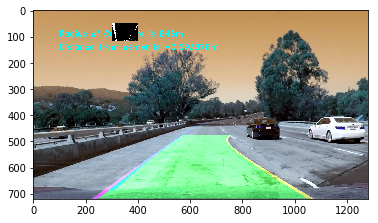

In [23]:
plt.imshow(pipeline(cv2.imread("test_images/test1.jpg")))


In [ ]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)